# Code Notebook

### Imports

In [4]:
import sqlite3 # database connection

import spacy # nlp
from spacytextblob.spacytextblob import SpacyTextBlob # nlp sentiment analysis
from spacy.lang.en.stop_words import STOP_WORDS # nlp stop words

import gensim # gensim
import gensim.corpora as corpora # gensim Corpora
from gensim.models import CoherenceModel # gensim CoherenceModel
from gensim.models import LdaModel # gensim LdaModel

import numpy as np # numpy arrays
import pandas as pd # dataframes
import networkx as nx # network visualization
import matplotlib.pyplot as plt # visualization
from matplotlib.pyplot import figure # visualization
from wordcloud import WordCloud, ImageColorGenerator # wordclouds
from collections import Counter # Counter-class

### Spacy Language Model & Pipeline Configuration

In [5]:
# language model -> maybe use different model? 
nlp = spacy.load('en_core_web_sm') 
# nlp pipeline extension
nlp.add_pipe("spacytextblob") 

### DB Connection

In [6]:
# cursor-object connection to database
conn = sqlite3.connect('hp-dataset-with-relations.sqlite')
c = conn.cursor()

# Sentiment Analysis

#### Sentiment assignment function

In [7]:
# define function to get the sentiments of a table
def calculate_sentiment(text):
    analysed = [nlp(line) for line in text]
    polarities = [l._.polarity for l in analysed]
    assessments = [l._.assessments for l in analysed]
    return assessments #-> see relevant words for assignment, example for presentation & reflexion
    #return polarities # returns sentiment between -1 and 1

#### Namelist of all available views in database

In [8]:
views = c.execute("SELECT tbl_name FROM sqlite_master where type='view'").fetchall()
views_names = [table[0] for table in views] 
views_names.remove('all_parts')

#### Single view test

In [9]:
sql = c.execute("SELECT dialog FROM ron_harry").fetchall()  
dialog = [i[0] for i in sql]
result = calculate_sentiment(dialog)
print(dialog)

['Harry, what is it?', 'Look at that one, Harry!', 'Up!!  Ooh!  Shut up, Harry.', "Oh, go on, Harry, Quidditch is great. Best game there is! And you'll be great, too!", 'Whoa. Harry, you never told me your father was a Seeker, too.', "Thats not just any broomstick, Harry.  It's a Nimbus 2000!", 'Harry wake up! Come on Harry, wake up!', 'Happy Christmas, Harry.', "That's me! Only, I'm head boy...and I'm holding the Quidditch cup! And bloody hell, I'm Quidditch Captain too! I look good. Harry, do you think this mirror shows the future?", "Harry, I know what you're thinking, but don't. There's something not quite right about that mirror.", 'Speak for yourself. All right there, Harry?', 'Ahh! Harry!', 'Harry!', "Oh, go on, Harry! If Snape can catch it on that old broomstick, you can! You're the youngest seeker in a century!", "It's obvious, isn't it? We've got to play our way across the room. All right. Harry, you take the Bishop's square. Hermione, you'll be the Queen's side castle. As fo

#### Create and visualize sentimentdistribution

In [9]:
# call function with every view
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql] #iterate on dialogrows
    result = calculate_sentiment(dialog) 
    narr = np.array(result)
    mean = np.mean(narr)
    
    # plot sentimentdistribution and mean as histogram for each table
    plt.title(table + ' | mean: ' + str(mean), family='monospace')
    x_axis = (-1, 1)
    if table.startswith('harry'):
        plt.hist(narr, range = x_axis, facecolor = 'black')
    else:
        plt.hist(narr, range = x_axis, facecolor = 'grey')
    
    # save distributions as .jpg files
    plt.savefig(table + '.jpg')
    # clear current figure
    plt.clf() 
    # print(table + ': || ' + str(mean) + ' ||' + str(result))

C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

### Visualize relations as colored networkgraph 

#### Create dataframe (from Harry)

In [10]:
# from Harry
tab = pd.DataFrame(columns={'from': [], 'name':[], 'mean':[]}) #create dataframe
print(tab)
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    result = calculate_sentiment(dialog)
    narr = np.array(result)
    mean = np.mean(narr)
    # ignore NaN fields
    if mean == 0 or mean < 0 or mean > 0: 
        # =from Harry
        if table.startswith('harry'): 
            # add tablenames and means to dataframe
            tab.loc[len(tab.index)]=["H", table, mean] 

Empty DataFrame
Columns: [from, name, mean]
Index: []


C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Visualize dataframe (from Harry)

In [11]:
tab

,from,name,mean
0,H,harry_ginny,-0.013654
1,H,harry_albus,0.011370
2,H,harry_arthurweasley,0.011719
3,H,harry_bellatrix,-0.166667
4,H,harry_crouch,0.000000
5,H,harry_dobby,0.062527
6,H,harry_draco,-0.020833
7,H,harry_fred,0.000000
8,H,harry_george,0.000000
9,H,harry_hermione,0.115572


#### Create networkgraph (from Harry)

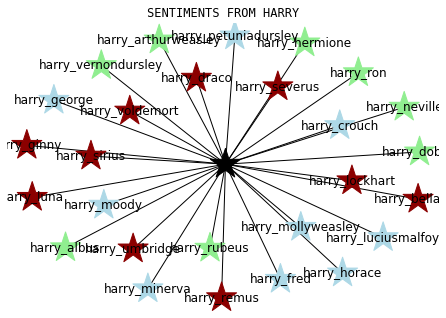

In [12]:
# use df to create networkgraph
G = nx.from_pandas_edgelist(tab, source='from', target='name', edge_attr='mean')
colors = ["black", "darkred", "lightgreen", "lightgreen", "darkred", "lightblue", "lightgreen", "darkred", "lightblue", "lightblue", "lightgreen", "lightblue","darkred", "lightblue","darkred", "lightblue", "lightblue", "lightblue", "lightgreen", "lightblue", "darkred", "lightgreen", "lightgreen", "darkred", "darkred", "darkred", "lightgreen", "darkred"]

nx.draw_spring(G, with_labels=True, node_shape='*', node_color = colors, node_size = 1000, edge_color='black', font_color="black")

plt.title("SENTIMENTS FROM HARRY", family='monospace')

plt.show()

#### Create dataframe (to Harry)

In [11]:
# to Harry
tab = pd.DataFrame(columns={'from': [], 'name':[], 'mean':[]})
print(tab)
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    result = calculate_sentiment(dialog)
    narr = np.array(result)
    mean = np.mean(narr)
    if mean == 0 or mean < 0 or mean > 0:
        if table.endswith('_harry'):
            tab.loc[len(tab.index)]=["H", table, mean]

Empty DataFrame
Columns: [from, name, mean]
Index: []


C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Teres\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Visualize dataframe (to Harry)

In [12]:
tab

,from,name,mean
0,H,albus_harry,0.121649
1,H,arthurweasley_harry,0.053125
2,H,bellatrix_harry,0.088934
3,H,crouch_harry,0.287599
4,H,dobby_harry,0.055942
5,H,draco_harry,0.084720
6,H,fred_harry,0.080000
7,H,fudge_harry,0.255139
8,H,george_harry,0.000000
9,H,ginny_harry,0.069727


#### Create networkgraph (to Harry)

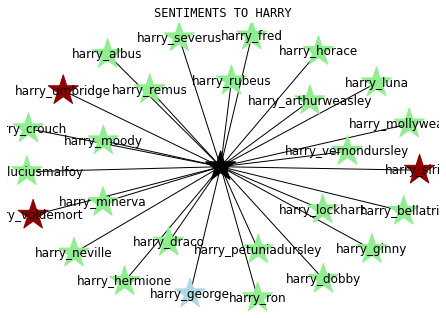

In [13]:
# use df to create networkgraph
G = nx.from_pandas_edgelist(tab, source='from', target='name', edge_attr='mean')
colors = ["black", "lightgreen", "lightgreen","lightgreen", "lightgreen", "lightgreen", "lightgreen", "lightgreen", "lightgreen", "lightblue", "lightgreen", "lightgreen", "lightgreen","lightgreen", "lightgreen","lightgreen","lightgreen","lightgreen","lightgreen","lightgreen","lightgreen","lightgreen","lightgreen","lightgreen", "darkred", "darkred", "lightgreen", "darkred"]
    
nx.draw_spring(G, with_labels=True, node_shape='*', node_color=colors, node_size=1000, edge_color='black', font_color="black")

plt.title("SENTIMENTS TO HARRY", family='monospace')

plt.show()

# Topic Modeling

## Attempt one

#### Text pre-processing

In [75]:
# load file
with open("all_parts.txt", "r", encoding='utf-8') as tf:
    text = tf.readlines()
    text = ''.join(text).replace('\n',' ')
    
    # turn all lines into a single string
    text = ''.join(text)
    
    # create doc-object
    doc = nlp(text.lower())

In [69]:
# load stopwords
stopwords = STOP_WORDS

# add extra stopwords
STOP_WORDS.add("'mr','ms','mrs','say','\s', 'said', 'says', 'saying', 'be', ' ', 'uh', 'oh', 'ah', 'ow', 'hey', 'whoa', 'ahh', 'sir', 'ohh' 'e', 'eh', 'whew', 'ahhhh', 'ahhh'")
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [76]:
# tokenize corpus and remove stopwords and punctuation
processed_corpus = [[token.text for token in doc if token.is_stop == False and       
token.text.isalpha() == True and not token.is_punct and not token.like_num]]

#### Bag of words

In [77]:
# map words to ids
dictionary = corpora.Dictionary(processed_corpus)

# create bag of words
corpus = [dictionary.doc2bow(txt) for txt in processed_corpus]

#### LdaModel

In [73]:
# run model with 5 topics
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
                    
# show topics
lda_model.show_topics()

[(0,
  '0.021*"harry" + 0.015*"know" + 0.009*"potter" + 0.008*"think" + 0.008*"got" + 0.007*"come" + 0.007*"oh" + 0.006*"like" + 0.006*"right" + 0.006*"yes"'),
 (1,
  '0.021*"harry" + 0.011*"know" + 0.008*"think" + 0.008*"come" + 0.008*"potter" + 0.007*"oh" + 0.007*"right" + 0.006*"yes" + 0.006*"professor" + 0.006*"got"'),
 (2,
  '0.015*"harry" + 0.011*"know" + 0.010*"potter" + 0.009*"come" + 0.008*"like" + 0.007*"think" + 0.007*"right" + 0.007*"oh" + 0.007*"dumbledore" + 0.006*"got"'),
 (3,
  '0.014*"harry" + 0.013*"know" + 0.008*"come" + 0.007*"potter" + 0.007*"like" + 0.007*"think" + 0.006*"yes" + 0.005*"right" + 0.005*"hermione" + 0.004*"oh"'),
 (4,
  '0.023*"harry" + 0.009*"know" + 0.009*"think" + 0.008*"potter" + 0.007*"come" + 0.007*"like" + 0.007*"right" + 0.006*"oh" + 0.006*"sir" + 0.005*"yes"')]

## Attempt two

### Test for a single table

In [85]:
# load single table
sql = c.execute("SELECT dialog FROM harry_voldemort").fetchall()
dialog = [i[0] for i in sql]

#### Clean text and create doc-object

In [86]:
# replace whitespaces and paragraphs
text = ''.join(dialog).replace('\n',' ')
    
# turn lines into a single string
text = ''.join(text)
    
# create doc-object
doc = nlp(text.lower())

#### Wordcloud for all words

In [87]:
# create list that contains tokenized words
all_words = []
for token in doc:
    if not token.is_stop and not token.is_punct and token.text.isalpha():
        all_words.append(token.text)

In [89]:
# pass list to instance of Counter class
counted_words = Counter(all_words)
  
# find most frequent input values and their counts
frequent_words = counted_words.most_common(20)
print(frequent_words)

[('voldemort', 20), ('tom', 9), ('riddle', 9), ('know', 7), ('got', 6), ('mean', 5), ('asked', 4), ('dumbledore', 4), ('felt', 4), ('kill', 3), ('diary', 3), ('sir', 3), ('believe', 3), ('destroy', 3), ('belonged', 3), ('tried', 2), ('thing', 2), ('killed', 2), ('blood', 2), ('come', 2)]


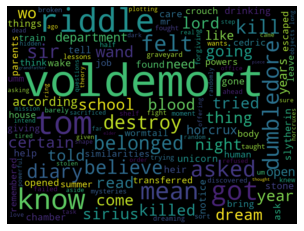

In [90]:
# create wordcloud object
wc = WordCloud(background_color="black", width=800,height=600)
# call the generate_from_frequencies function
wc.generate_from_frequencies(counted_words)

# plot wordcloud
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
#wc.to_file('words_voldemort_harry.png')

#### Wordcloud for all nouns

In [94]:
# create list that contains only nouns
nouns = []
for token in doc:
    if not token.is_stop and not token.is_punct and token.text.isalpha() and token.pos_ == "NOUN":
        nouns.append(token.text)

In [95]:
# pass list to instance of the Counter class
counted_nouns = Counter(nouns)
  
# find most frequent input values and their counts
frequent_nouns = counted_nouns.most_common(50)
print(frequent_nouns)

[('voldemort', 20), ('riddle', 9), ('tom', 8), ('dumbledore', 4), ('diary', 3), ('sir', 3), ('thing', 2), ('blood', 2), ('night', 2), ('dream', 2), ('school', 2), ('wand', 2), ('lord', 2), ('year', 2), ('sirius', 2), ('department', 2), ('years', 2), ('horcrux', 2), ('unicorn', 1), ('stone', 1), ('parents', 1), ('chamber', 1), ('heir', 1), ('slytherin', 1), ('things', 1), ('similarities', 1), ('powers', 1), ('train', 1), ('umm', 1), ('job', 1), ('summer', 1), ('house', 1), ('wormtail', 1), ('mr', 1), ('crouch', 1), ('body', 1), ('graveyard', 1), ('moment', 1), ('mysteries', 1), ('lessons', 1), ('fight', 1), ('shelf', 1), ('task', 1), ('mission', 1), ('snape', 1), ('questions', 1), ('love', 1), ('order', 1), ('office', 1), ('theory', 1)]


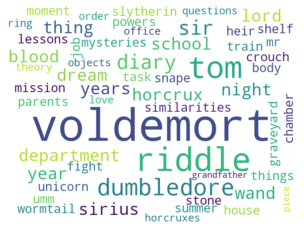

In [96]:
# create a wordcloud object
wc = WordCloud(background_color="white", width=800, height=600)
# call generate_from_frequencies function
wc.generate_from_frequencies(counted_nouns)

# plot wordcloud
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
#wc.to_file('nouns_voldemort_harry.png')

### Wordclouds for all tables

#### All words

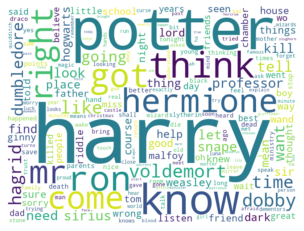

In [98]:
# call function with every view
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    
    # create doc-object without whitespaces and paragraphs and in lowercase as a single string
    text = ''.join(dialog).replace('\n',' ')
    text = ''.join(text)
    doc = nlp(text.lower())
    
    # create list that contains tokenized words
    all_words = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.text.isalpha():
            all_words.append(token.text)
            
    # pass list to instance of Counter class
    counted_words = Counter(all_words)
    
    # check length
    if len(all_words) > 0:
        # create wordcloud object and call the generate_from_frequencies function
        if table.startswith('harry'):
            wc = WordCloud(background_color="black", width=800,height=600)
            wc.generate_from_frequencies(counted_words)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
        else:
            wc = WordCloud(background_color="white", width=800,height=600)
            wc.generate_from_frequencies(counted_words)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")

        wc.to_file(table + '_allwords.jpg')

#### Nouns

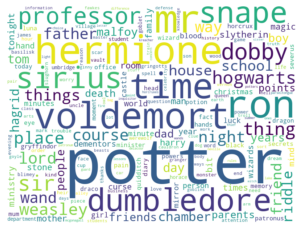

In [102]:
# call function with every view
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    
    # create doc-object without whitespaces and paragraphs and in lowercase as a single string
    text = ''.join(dialog).replace('\n',' ')
    text = ''.join(text)
    doc = nlp(text.lower())
    
    # create list that contains nouns
    nouns = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.text.isalpha() and token.pos_ == "NOUN":
            nouns.append(token.text)
            
    # pass list to instance of Counter class
    counted_nouns = Counter(nouns)
    
    # check length
    if len(nouns) > 0:
        # create wordcloud object and call the generate_from_frequencies function
        if table.startswith('harry'):
            wc = WordCloud(background_color="black", width=800,height=600)
            wc.generate_from_frequencies(counted_nouns)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
        else:
            wc = WordCloud(background_color="white", width=800,height=600)
            wc.generate_from_frequencies(counted_nouns)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")

        wc.to_file(table + '_nouns.jpg')

#### Adjectives

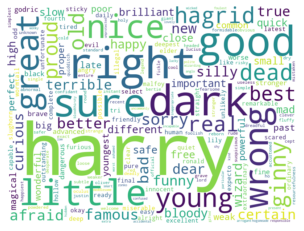

In [103]:
# call function with every view
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    
    # create doc-object without whitespaces and paragraphs and in lowercase as a single string
    text = ''.join(dialog).replace('\n',' ')
    text = ''.join(text)
    doc = nlp(text.lower())
    
    # create list that contains asjectives
    adj = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.text.isalpha() and token.pos_ == "ADJ":
            adj.append(token.text)
            
    # pass list to instance of Counter class
    counted_adj = Counter(adj)
    
    # check length
    if len(adj) > 0:
        # create wordcloud object and call the generate_from_frequencies function
        if table.startswith('harry'):
            wc = WordCloud(background_color="black", width=800,height=600)
            wc.generate_from_frequencies(counted_adj)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
        else:
            wc = WordCloud(background_color="white", width=800,height=600)
            wc.generate_from_frequencies(counted_adj)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")

        wc.to_file(table + '_adj.jpg')

#### Verbs

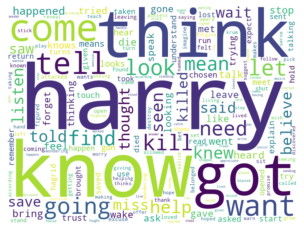

In [106]:
# call function with every view
for table in views_names:
    sql = c.execute("SELECT dialog FROM " + table).fetchall()  
    dialog = [i[0] for i in sql]
    
    # create doc-object without whitespaces and paragraphs and in lowercase as a single string
    text = ''.join(dialog).replace('\n',' ')
    text = ''.join(text)
    doc = nlp(text.lower())
    
    # create list that contains verbs
    verb = []
    for token in doc:
        if not token.is_stop and not token.is_punct and token.text.isalpha() and token.pos_ == "VERB":
            verb.append(token.text)
            
    # pass list to instance of Counter class
    counted_verb = Counter(verb)
    
    # check length
    if len(verb) > 0:
        # create wordcloud object and call the generate_from_frequencies function
        if table.startswith('harry'):
            wc = WordCloud(background_color="black", width=800,height=600)
            wc.generate_from_frequencies(counted_verb)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
        else:
            wc = WordCloud(background_color="white", width=800,height=600)
            wc.generate_from_frequencies(counted_verb)
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")

        wc.to_file(table + '_verb.jpg')